# Crowdedness in the Gym

You like to go to the gym; however, you hate getting to the gym and finding that it is so crowded that you must wait to use the machines you want.

I will build a model that will help you predict the best time to go to the gym and avoid crowds, so you can enjoy a great workout with minimal wait times and no crowds.

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


# Read in the data
gym = pd.read_csv('gym.csv')

## Exploratory Data Analysis

In [113]:
# Have a quick look at the data
gym.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [114]:
# Check columns, size and quality
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


In [115]:
# Change date to datetime
gym['date'] = pd.to_datetime(gym['date'],utc=True)
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   number_people         62184 non-null  int64              
 1   date                  62184 non-null  datetime64[ns, UTC]
 2   timestamp             62184 non-null  int64              
 3   day_of_week           62184 non-null  int64              
 4   is_weekend            62184 non-null  int64              
 5   is_holiday            62184 non-null  int64              
 6   temperature           62184 non-null  float64            
 7   is_start_of_semester  62184 non-null  int64              
 8   is_during_semester    62184 non-null  int64              
 9   month                 62184 non-null  int64              
 10  hour                  62184 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(9)
memory usage: 5.2 M

We are interested in avoiding crowds so our variable of interest will be number_people.

In [116]:
# How long were the obersvations collected?
earliest = gym['date'].min()
latest = gym['date'].max()
diff = (latest - earliest)
diff

Timedelta('582 days 02:22:40')

Text(0.5, 1.0, 'Average number of people per day of week')

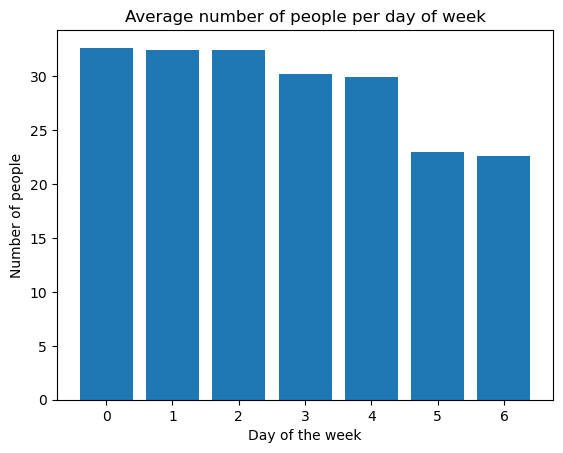

In [117]:
# How many people on average per day of the week? Monday = 0
ppd = gym.groupby('day_of_week')['number_people'].mean()
plt.bar(ppd.index, ppd.values,)
plt.xlabel('Day of the week')
plt.ylabel('Number of people')
plt.title('Average number of people per day of week')

Text(0.5, 1.0, 'Average number of people per month')

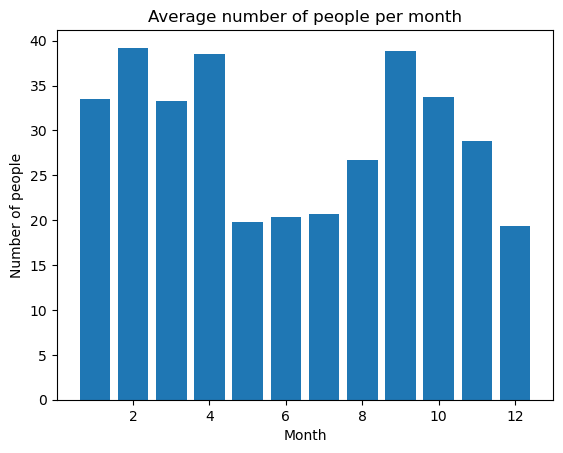

In [118]:
# How many people on average per month? January = 1
ppm = gym.groupby('month')['number_people'].mean()
plt.bar(ppm.index, ppm.values,)
plt.xlabel('Month')
plt.ylabel('Number of people')
plt.title('Average number of people per month')

Text(0.5, 1.0, 'Average number of people per hour of the day')

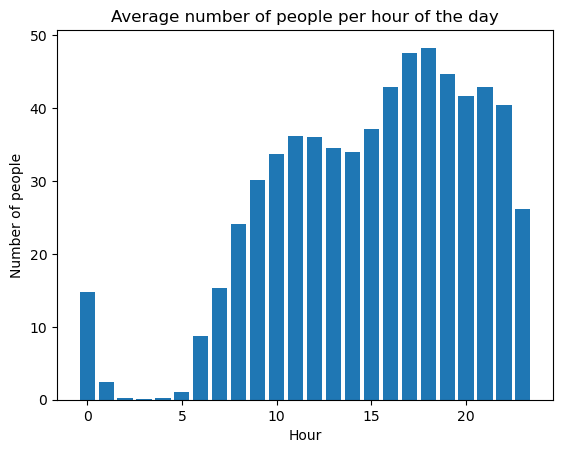

In [119]:
# How many people on average per hour of the day? 12am = 0
pph = gym.groupby('hour')['number_people'].mean()
plt.bar(pph.index, pph.values,)
plt.xlabel('Hour')
plt.ylabel('Number of people')
plt.title('Average number of people per hour of the day')

<Axes: >

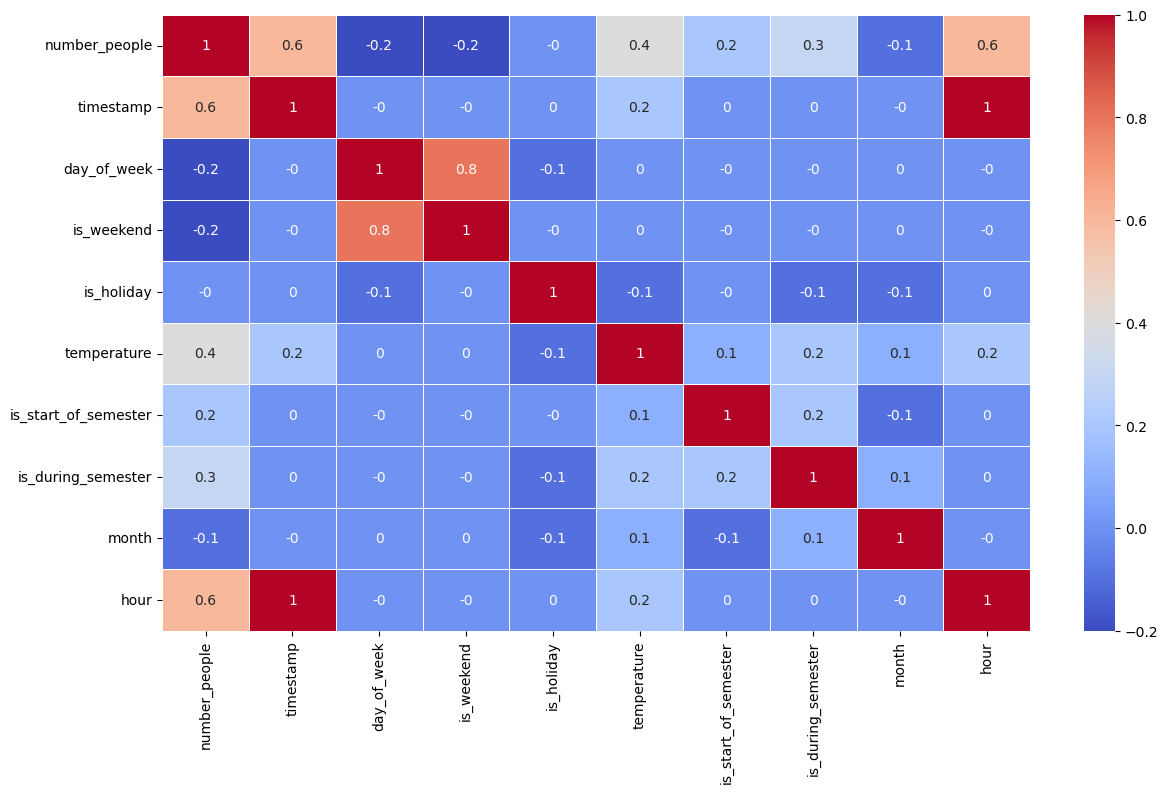

In [120]:
# Run correlations
num_col = gym.drop('date', axis=1)
corrs = gym[num_col.columns].corr()

# Map out correlations
plt.figure(figsize=(14, 8))
sns.heatmap(round(corrs,1), 
            xticklabels=corrs.columns, 
            yticklabels=corrs.columns,
            cmap='coolwarm', 
            annot=True, 
            linewidths=.5) 

There are a few promising correlations amongst the dataset. Our number_people column correlates...

...moderatly with timestamp, hour and temperature

...weakly with is_during_semester, is_start_of_semester, day_of_week and is_weekend.

In [121]:
# Remove extraneous variables
gym_clean = gym[['number_people','day_of_week','timestamp','hour','temperature','is_during_semester', 'is_start_of_semester','is_weekend']]

## Building Our Model - 1

In [122]:
# Split the dataset
X = gym_clean.drop('number_people', axis=1)
y = gym_clean['number_people']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=407)

In [123]:
# Build and train the SDGRegressor model
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
sgdr = SGDRegressor(max_iter=10000,tol=0.0001,eta0=0.0001)               
sgdr.fit(X_train, y_train)           
y_pred = sgdr.predict(X_test)
rmse = mean_squared_error(y_test,y_pred,squared=False)
r_two = r2_score(y_test, y_pred)
rmse,r_two

(16.245311855666603, 0.48289487472305526)

This wasn't a great result so I'm going to try again. 

## Building Our Model - 2

In [124]:
# Remove non-moderately correlated variables
X_2 = gym[['timestamp','hour','temperature']]

In [125]:
# Split the dataset
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,y,random_state=407)

In [126]:
# Build and train the SDGRegressor model
scaler = StandardScaler()
scaler.fit(X_train_2)
X_train_2 = scaler.transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)
sgdr_2 = SGDRegressor(max_iter=10000,tol=0.0001,eta0=0.0001)               
sgdr_2.fit(X_train_2, y_train_2)           
y_pred_2 = sgdr_2.predict(X_test_2)
rmse_2 = mean_squared_error(y_test_2,y_pred_2,squared=False)
r_two_2 = r2_score(y_test_2, y_pred_2)
rmse_2,r_two_2

(17.93637287787855, 0.36963515554357373)

Even worse so let's go again. 

## Building Our Model - 3

In [127]:
# Add another nearly moderately correlated variable
X_3 = gym[['timestamp','hour','temperature','is_during_semester']]

In [128]:
# Split the dataset
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3,y,random_state=407)

In [129]:
# Build and train the SDGRegressor model
scaler = StandardScaler()
scaler.fit(X_train_3)
X_train_3 = scaler.transform(X_train_3)
X_test_3 = scaler.transform(X_test_3)
sgdr_3 = SGDRegressor(max_iter=10000,tol=0.0001,eta0=0.0001)               
sgdr_3.fit(X_train_3, y_train_3)           
y_pred_3 = sgdr_3.predict(X_test_3)
rmse_3 = mean_squared_error(y_test_3,y_pred_3,squared=False)
r_two_3 = r2_score(y_test_3, y_pred_3)
rmse_3,r_two_3

(16.877643906579664, 0.44185585138480077)

Better but worse than the first model so I'm going to add another variable to the first one. 

## Building Our Model - 4

In [137]:
# Add another correlated variable
X_4 = gym[['month','day_of_week','hour','temperature','is_during_semester', 'is_start_of_semester','is_weekend']]

In [138]:
# Split the dataset
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4,y,random_state=407)

In [139]:
# Build and train the SDGRegressor model
scaler = StandardScaler()
scaler.fit(X_train_4)
X_train_4 = scaler.transform(X_train_4)
X_test_4 = scaler.transform(X_test_4)
sgdr_4 = SGDRegressor(max_iter=10000,tol=0.0001,eta0=0.0001)               
sgdr_4.fit(X_train_4, y_train_4)           
y_pred_4 = sgdr_4.predict(X_test_4)
rmse_4 = mean_squared_error(y_test_4,y_pred_4,squared=False)
r_two_4 = r2_score(y_test_4, y_pred_4)
rmse_4,r_two_4

(16.065863969772955, 0.49425580371817557)

The last model saw some improvement but it's still not great. 

## Visualize the Results

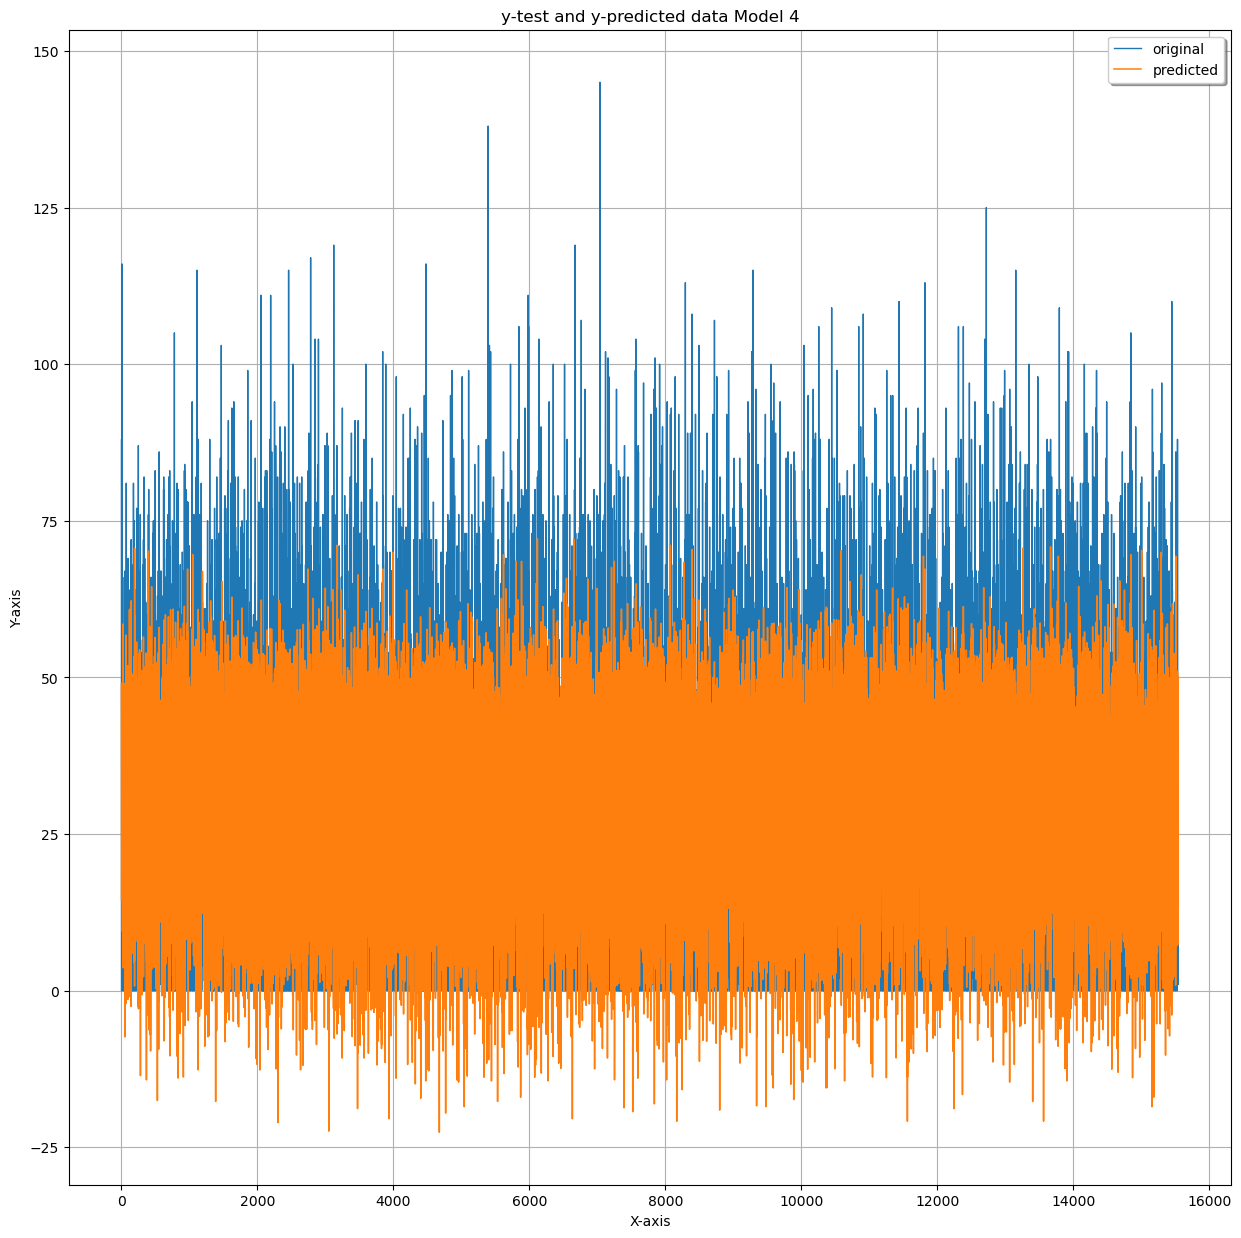

In [140]:
plt.figure(figsize=(15, 15))

x_ax = range(len(y_test_4))
plt.plot(x_ax, y_test_4, linewidth=1, label="original")
plt.plot(x_ax, y_pred_4, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data Model 4")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

## So what are some good times to head to the gym?
I've created a dataset of relevant times - weekdays only, before or after work/school, during semester. I will run it through the model to see what times it will recommend. 

In [164]:
# Read in the data
gym_times = pd.read_csv('gym_times 2.csv')

# Scale the data
gym_times_scale = scaler.transform(gym_times)

# Make the predictions
gym_time_preds = sgdr_4.predict(gym_times_scale)

# What's the range of values?
low_ppl = gym_time_preds.min()
hi_ppl = gym_time_preds.max()
low_ppl,hi_ppl

# Add the predictions back into the dataset
gym_times['predicted_ppl'] = gym_time_preds

# Filter the dataset to get some good times
best_times = gym_times[gym_times['predicted_ppl']<20]
best_times

,month,day_of_week,hour,temperature,is_during_semester,is_start_of_semester,is_weekend,predicted_ppl
36,5,0,5,50.0,1,0,0,19.269931
45,6,0,5,50.0,1,0,0,18.499697
54,7,0,5,50.0,1,0,0,17.729464
63,8,0,5,50.0,1,0,0,16.959230
72,9,0,5,50.0,1,0,0,16.188996
81,10,0,5,50.0,1,0,0,15.418762
90,11,0,5,50.0,1,0,0,14.648528
91,11,0,6,53.6,1,0,0,19.465419
99,12,0,5,50.0,1,0,0,13.878295
100,12,0,6,53.6,1,0,0,18.695185


## Summary

This work does give some indication as to when we can optimise our gym time to avoid other people. If you want to be there with less than 20 people, you've got to go early, 5am. That is during the week and semester and outside of business hours. 

There is still work to do to refine it. We could continue to tweak the hyperparameters and also re-look at the features to make sure they are optimised.